# Demand Forecast

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', dtype = {'StateHoliday': str})
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

### Exploratory Data Analysis

In [5]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
train['StateHoliday'].value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [8]:
train.shape

(1017209, 9)

In [9]:
train = pd.merge(train, store, on = 'Store', how = 'left')
test = pd.merge(test, store, on = 'Store', how = 'left')

In [10]:
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [11]:
train.sort_values(['Store','Date'], ignore_index = True, inplace = True)
test.sort_values(['Store','Date'], ignore_index = True, inplace = True)

for dataset in (train,test):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day']  = dataset.Date.dt.day
    dataset['Month']  = dataset.Date.dt.month
    dataset['Year']  = dataset.Date.dt.year
    dataset['DayOfYear']  = dataset.Date.dt.dayofyear
    dataset.set_index('Date', inplace = True)

In [12]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Month,Year,DayOfYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,1.570279e+01,5.846762e+00,2.013832e+03,1.622764e+02
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,8.787638e+00,3.326097e+00,7.773960e-01,1.016162e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,8.000000e+00,3.000000e+00,2.013000e+03,7.700000e+01
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,1.600000e+01,6.000000e+00,2.014000e+03,1.530000e+02
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,2.300000e+01,8.000000e+00,2.014000e+03,2.410000e+02
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,3.100000e+01,1.200000e+01,2.015000e+03,3.650000e+02


array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Customers'}>],
       [<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>,
        <Axes: title={'center': 'SchoolHoliday'}>,
        <Axes: title={'center': 'CompetitionDistance'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceMonth'}>,
        <Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'DayOfYear'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

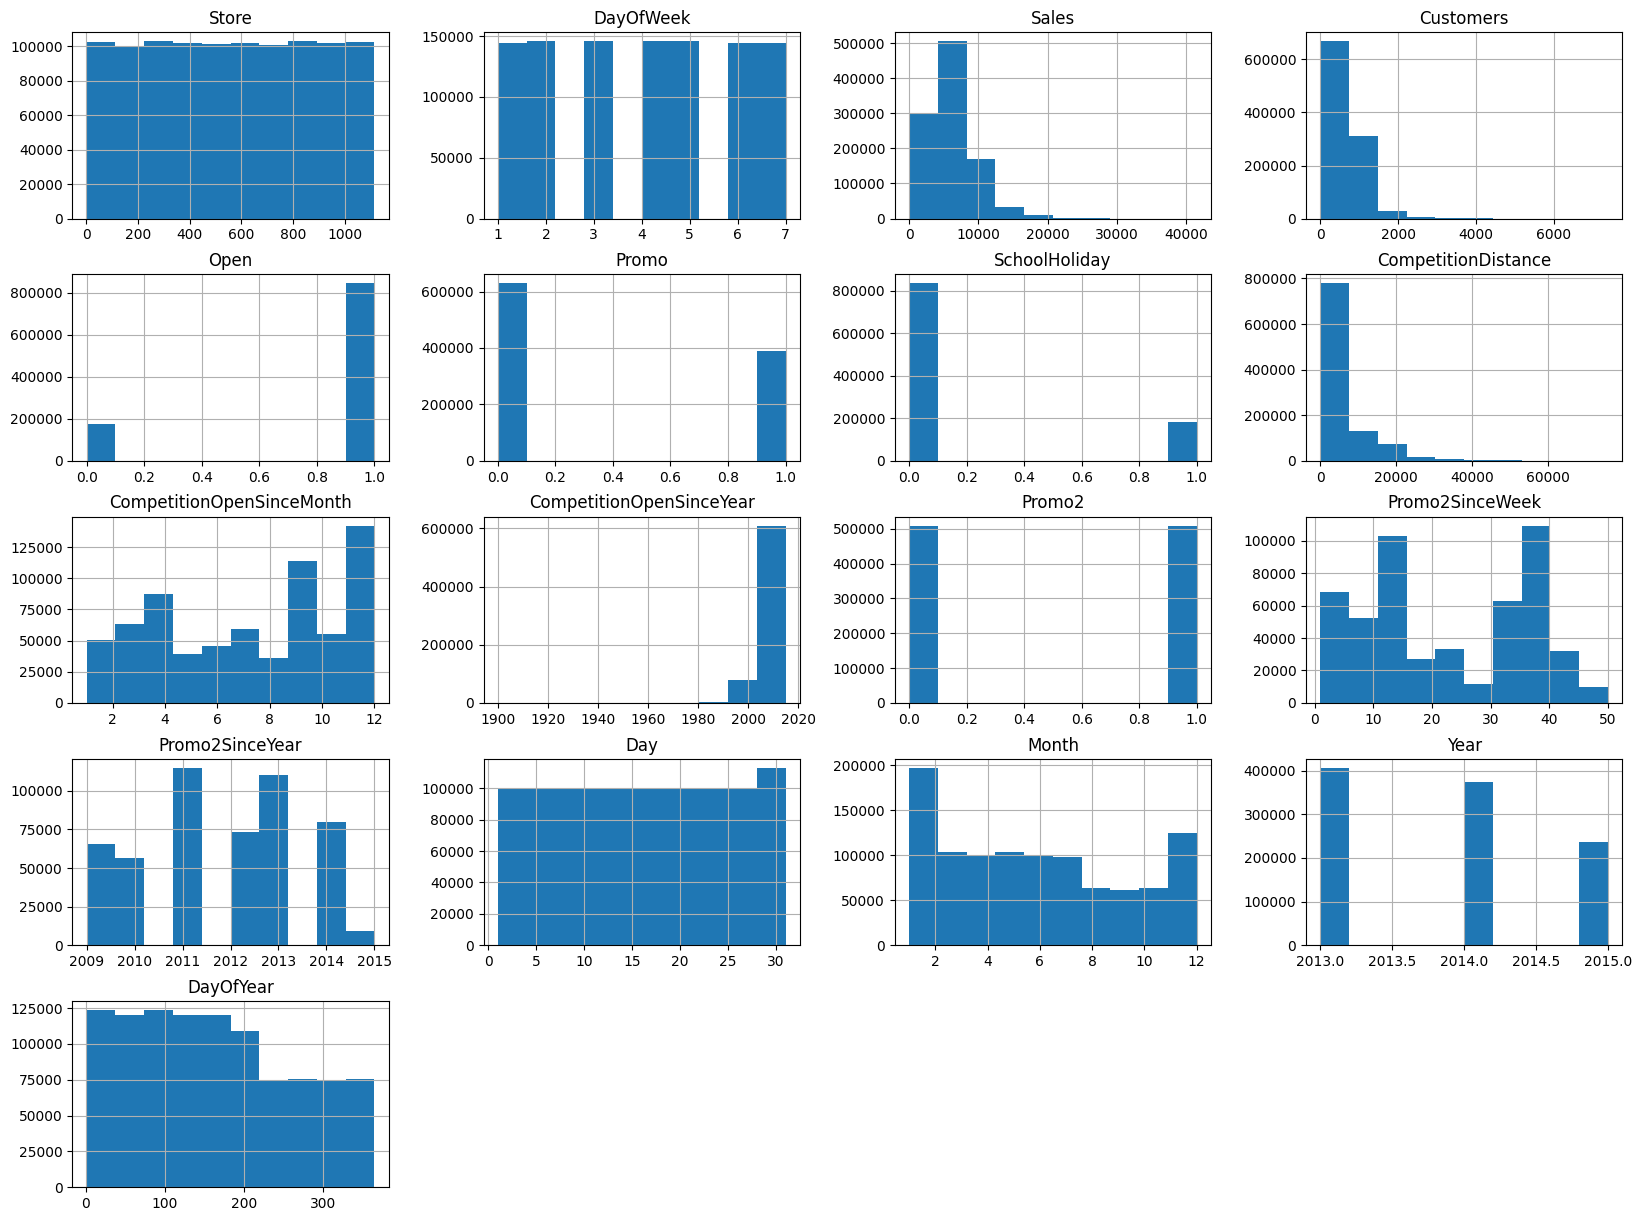

In [13]:
train.hist(figsize = (20,15))

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Open'}>],
       [<Axes: title={'center': 'Promo'}>,
        <Axes: title={'center': 'SchoolHoliday'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>,
        <Axes: title={'center': 'Promo2SinceYear'}>],
       [<Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'DayOfYear'}>]], dtype=object)

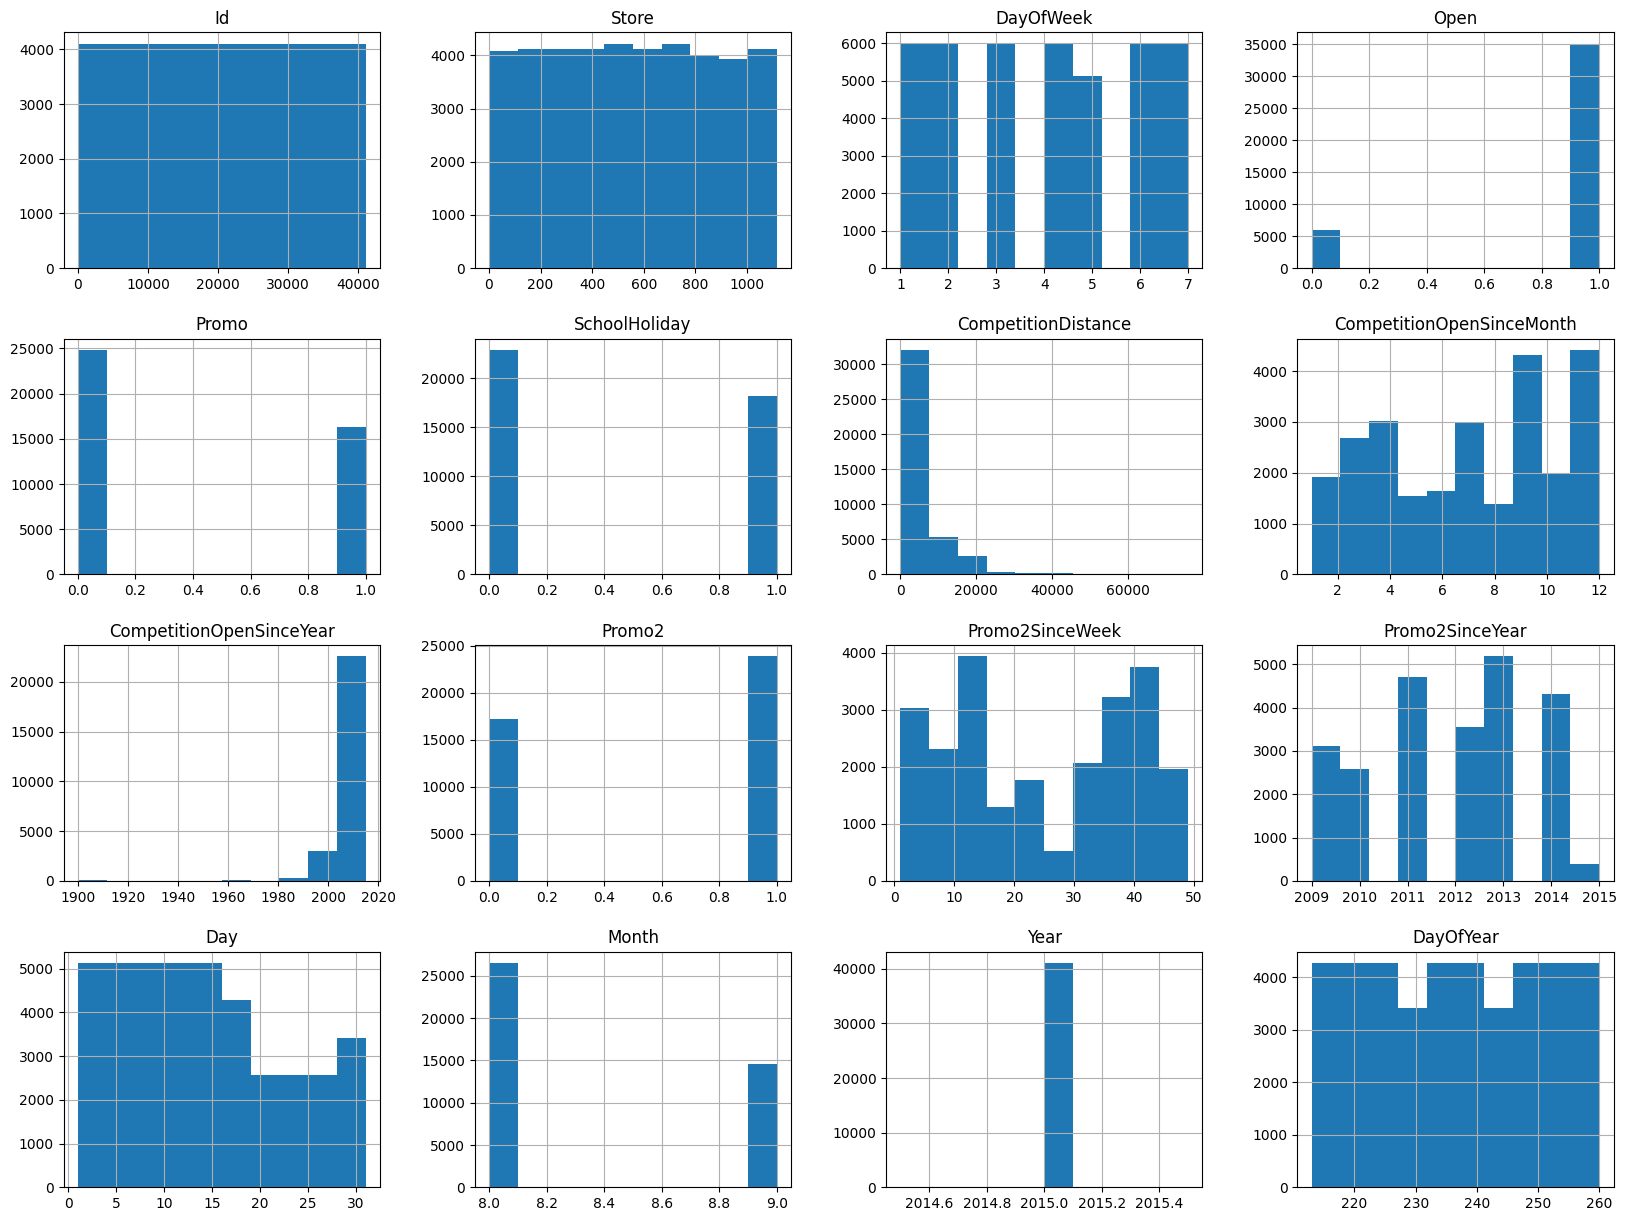

In [14]:
test.hist(figsize = (20,15))

#### Customer column is absent in test set

#### We can see that there are lot of 0 sales probalbly when Store is Closed

[]

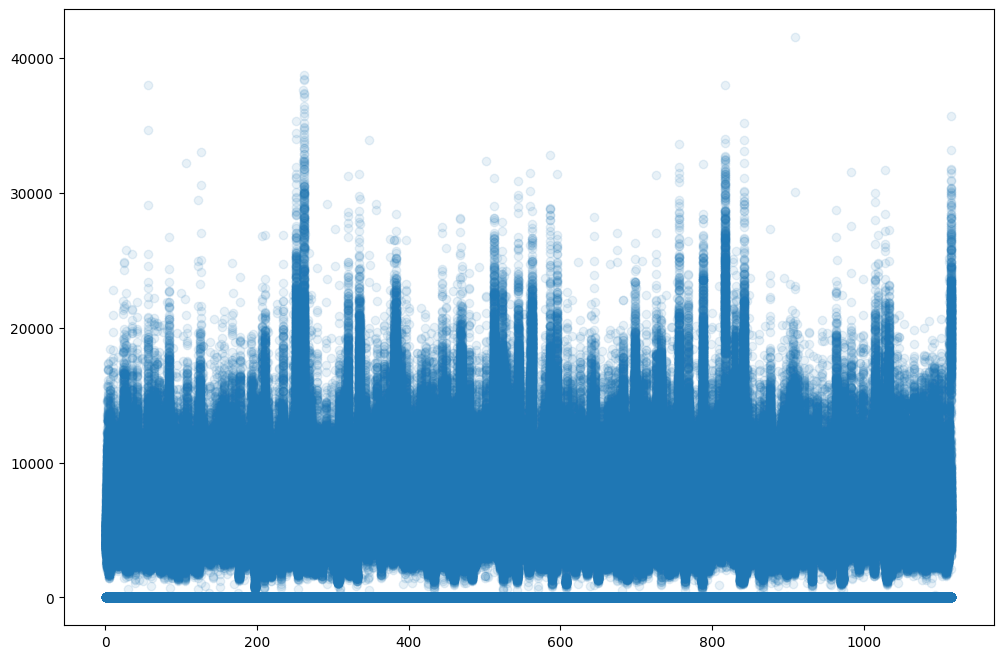

In [15]:
plt.figure(figsize = (12,8))
plt.scatter(train['Store'],train['Sales'], alpha = 0.1)
plt.plot()

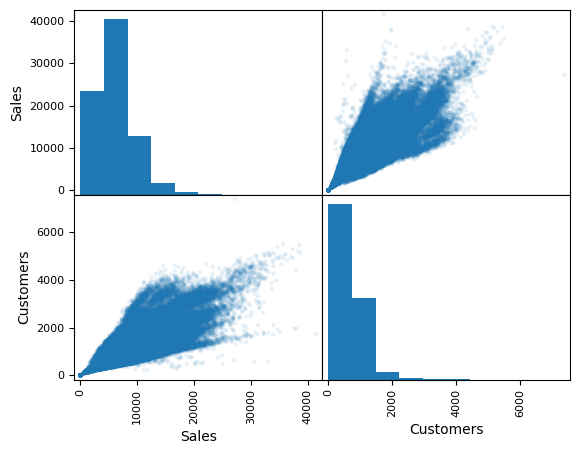

In [16]:
#Sales_Customers
attributes = ["Sales", "Customers"]
scatter_matrix(train[attributes], alpha=0.1);

[]

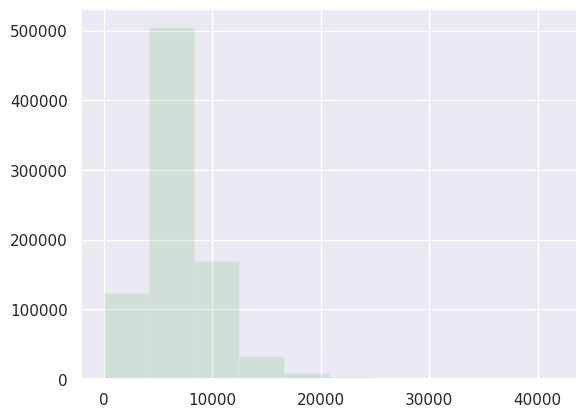

In [17]:
sns.set()
plt.hist(train[train['Open'] == 1].Sales , color = 'green', alpha = 0.1 , label = 'Yes')
plt.hist(train[train['Open'] == 0].Sales , color = 'red', alpha = 0.1 , label = 'No')
plt.legend
plt.plot()

### The chart tells that doing promo does not necessarily increase sales, The continuous promo is almost similar to the stores that do not to promo

[]

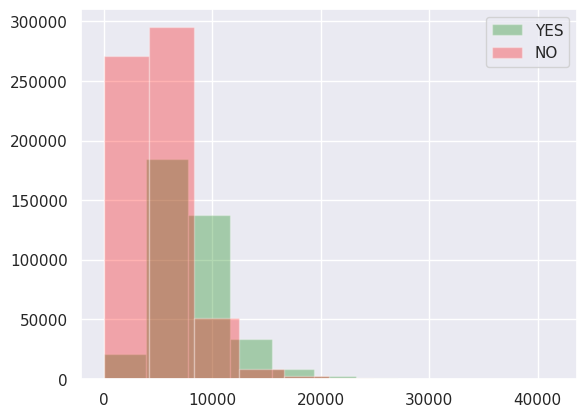

In [18]:
#Sales_Promo
sns.set()
plt.hist(train[train['Promo'] == 1].Sales, color='green', alpha=0.3, label = 'YES')
plt.hist(train[train['Promo'] == 0].Sales, color='red', alpha=0.3, label = 'NO')
plt.legend()
plt.plot()

[]

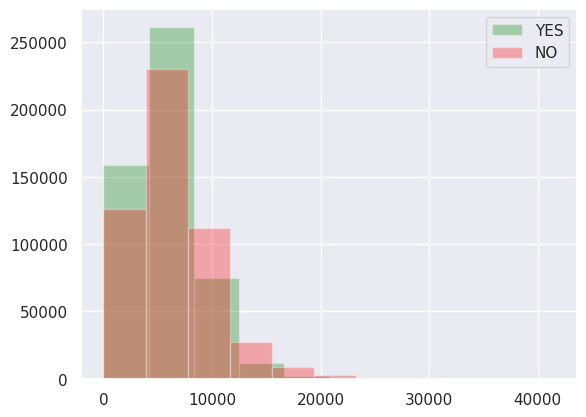

In [19]:
#Sales_Promo2
sns.set()
plt.hist(train[train['Promo2'] == 1].Sales, color='green', alpha=0.3, label = 'YES')
plt.hist(train[train['Promo2'] == 0].Sales, color='red', alpha=0.3, label = 'NO')
plt.legend()
plt.plot()

[]

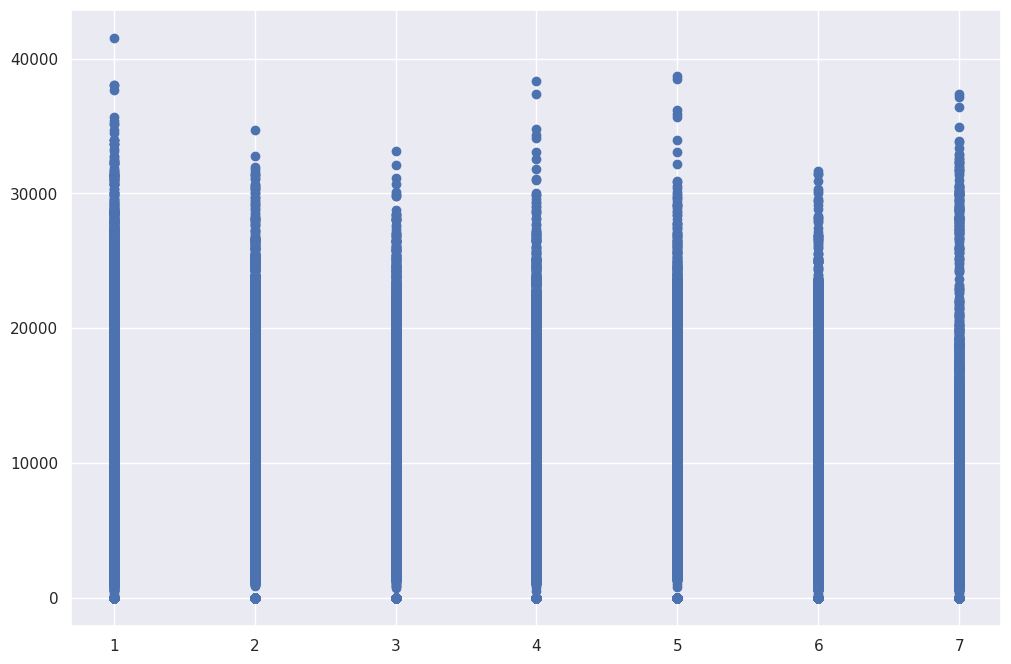

In [20]:
plt.figure(figsize = (12,8))
plt.scatter(train['DayOfWeek'], train['Sales'])
plt.plot()

#### There is high sales in April, May, June and December
#### Low sales in January and September


[]

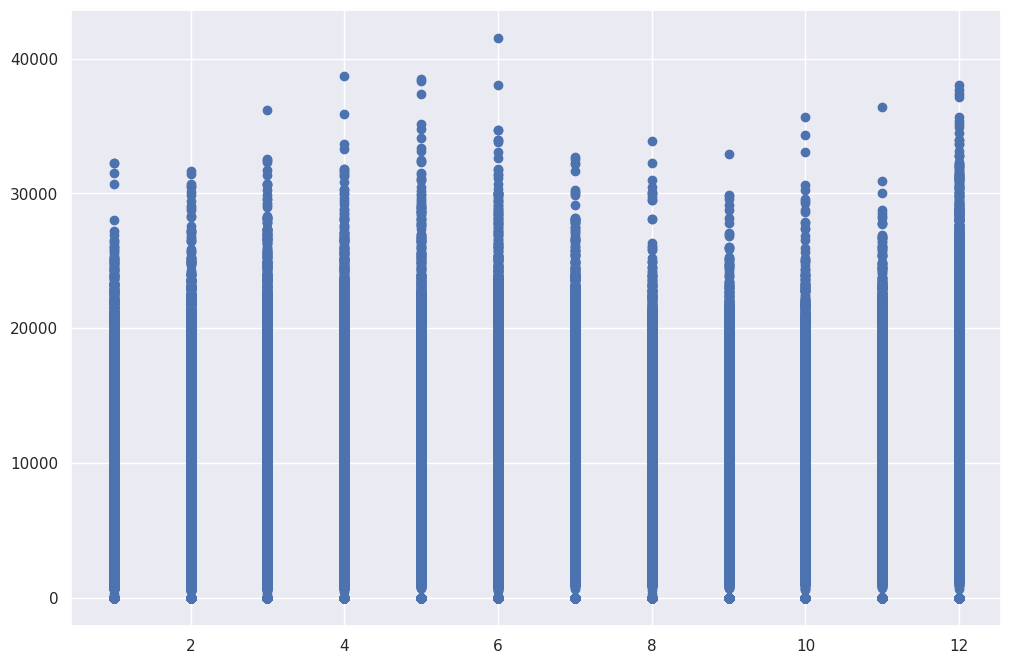

In [21]:
plt.figure(figsize = (12,8))
plt.scatter(train['Month'], train['Sales'])
plt.plot()

#### This shows the sales in particualar type of stores (a,b,c,d) Store type a and d has more sales

[]

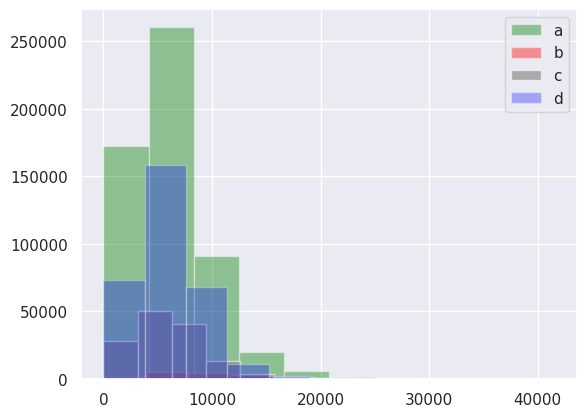

In [22]:
sns.set()
plt.hist(train[train['StoreType'] == 'a'].Sales , color = 'green', alpha = 0.4 , label = 'a')
plt.hist(train[train['StoreType'] == 'b'].Sales , color = 'red', alpha = 0.4 , label = 'b')
plt.hist(train[train['StoreType'] == 'c'].Sales , color = 'grey', alpha = 0.6 , label = 'c')
plt.hist(train[train['StoreType'] == 'd'].Sales , color = 'blue', alpha = 0.3 , label = 'd')
plt.legend()
plt.plot()

<Axes: xlabel='DayOfWeek', ylabel='count'>

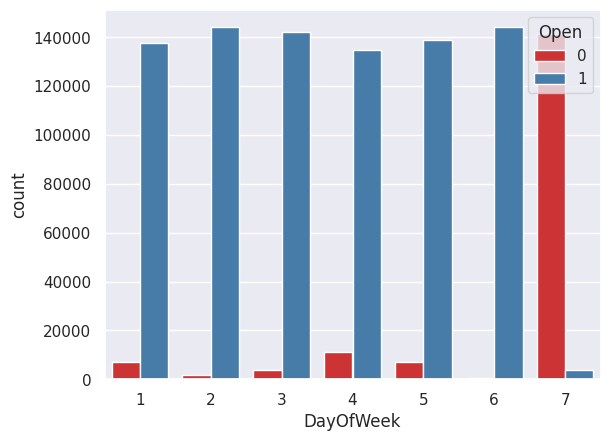

In [23]:
# open day of week
sns.countplot(x = 'DayOfWeek', data = train,hue = 'Open' ,palette = 'Set1')

### Feature Engineering 

In [24]:
# Get total sales, customers and open days per store
store_data_sales = train.groupby(['Store'])['Sales'].sum()
store_data_customers = train.groupby(['Store'])['Customers'].sum()
store_data_avg_sales = train.groupby(['Store'])['Sales'].mean()
store_data_avg_customers = train.groupby(['Store'])['Customers'].mean()
store_data_open = train.groupby(['Store'])['Open'].count()

# Calculate derived metrics
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_avg_sales_per_customer = store_data_avg_sales / store_data_avg_customers
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

# Store-level dictionaries
sales_per_day_dict = dict(store_data_sales_per_day)
customers_per_day_dict = dict(store_data_customers_per_day)
avg_sales_per_customer_dict = dict(store_data_avg_sales_per_customer)
sales_per_customers_per_day_dict = dict(store_data_sales_per_customer_per_day)

# Map values back to train and test sets
train['SalesPerDay'] = train['Store'].map(sales_per_day_dict)
train['Customers_per_day'] = train['Store'].map(customers_per_day_dict)
train['Avg_Sales_per_Customer'] = train['Store'].map(avg_sales_per_customer_dict)
train['Sales_Per_Customers_Per_Day'] = train['Store'].map(sales_per_customers_per_day_dict)

test['Sales_per_day'] = test['Store'].map(sales_per_day_dict)
test['Customers_per_day'] = test['Store'].map(customers_per_day_dict)
test['Avg_Sales_per_Customer'] = test['Store'].map(avg_sales_per_customer_dict)
test['Sales_Per_Customers_Per_Day'] = test['Store'].map(sales_per_customers_per_day_dict)

In [25]:
train.drop('Customers', inplace = True, axis = 1)
train.drop('StateHoliday',inplace=True,axis=1)  
test.drop('StateHoliday',inplace=True,axis=1)

### Handling Missing Values

In [26]:
train.isnull().sum().sort_values(ascending = False)


Promo2SinceWeek                508031
PromoInterval                  508031
Promo2SinceYear                508031
CompetitionOpenSinceYear       323348
CompetitionOpenSinceMonth      323348
CompetitionDistance              2642
Store                               0
StoreType                           0
SchoolHoliday                       0
Promo                               0
Open                                0
Sales                               0
DayOfWeek                           0
Assortment                          0
Promo2                              0
Day                                 0
Month                               0
Year                                0
DayOfYear                           0
SalesPerDay                         0
Customers_per_day                   0
Avg_Sales_per_Customer              0
Sales_Per_Customers_Per_Day         0
dtype: int64

In [27]:
feat = ['PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionDistance']
modes = train[feat].mode()

for f in feat:
    train[f]  = train[f].fillna(modes[f][0])
    test[f] = test[f].fillna(modes[f][0])

In [28]:
train.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                          0
Open                           0
Promo                          0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
Day                            0
Month                          0
Year                           0
DayOfYear                      0
SalesPerDay                    0
Customers_per_day              0
Avg_Sales_per_Customer         0
Sales_Per_Customers_Per_Day    0
dtype: int64

In [29]:
train = train[train['Sales'] < 25000]
train.reset_index(drop = True)

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,SalesPerDay,Customers_per_day,Avg_Sales_per_Customer,Sales_Per_Customers_Per_Day
0,1,2,0,0,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2013,1,3945.704883,467.646497,8.437366,8.437366
1,1,3,5530,1,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",2,1,2013,2,3945.704883,467.646497,8.437366,8.437366
2,1,4,4327,1,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",3,1,2013,3,3945.704883,467.646497,8.437366,8.437366
3,1,5,4486,1,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",4,1,2013,4,3945.704883,467.646497,8.437366,8.437366
4,1,6,4997,1,0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",5,1,2013,5,3945.704883,467.646497,8.437366,8.437366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016445,1115,1,10712,1,1,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",27,7,2015,208,5225.296178,358.687898,14.567807,14.567807
1016446,1115,2,8093,1,1,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",28,7,2015,209,5225.296178,358.687898,14.567807,14.567807
1016447,1115,3,7661,1,1,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",29,7,2015,210,5225.296178,358.687898,14.567807,14.567807
1016448,1115,4,8405,1,1,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",30,7,2015,211,5225.296178,358.687898,14.567807,14.567807


#### Training the data on only when the store is open

In [30]:
train = train[train['Open'] == 1]
train = train[train['Sales'] > 0.0]

### Label Encoding

In [31]:
attributes = ['StoreType', 'Assortment', 'PromoInterval']
le = LabelEncoder()

for col in attributes:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

## XGBoost

In [32]:
train_df = train.drop(['Sales'], axis = 1)
y_t = train['Sales']

X_train,X_val,y_train,y_val = train_test_split(train_df, y_t, test_size=0.2, random_state=42)

# 2. Initialize the model
model = xgb.XGBRegressor(
    tree_method='hist',  # This enables GPU acceleration
    device = 'cuda',
    n_estimators= 2000,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

In [33]:
model.fit(
    X_train,y_train,
    eval_set = [(X_val,y_val)],
    early_stopping_rounds = 50,
    verbose = 50
)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2805.62829
[50]	validation_0-rmse:976.94531
[100]	validation_0-rmse:877.56735
[150]	validation_0-rmse:830.00646
[200]	validation_0-rmse:798.49451
[250]	validation_0-rmse:767.10529
[300]	validation_0-rmse:743.59952
[350]	validation_0-rmse:728.31122
[400]	validation_0-rmse:713.58597
[450]	validation_0-rmse:700.50504
[500]	validation_0-rmse:692.45545
[550]	validation_0-rmse:682.53067
[600]	validation_0-rmse:674.96467
[650]	validation_0-rmse:668.71524
[700]	validation_0-rmse:662.06545
[750]	validation_0-rmse:656.94319
[800]	validation_0-rmse:652.30883
[850]	validation_0-rmse:647.66403
[900]	validation_0-rmse:644.45073
[950]	validation_0-rmse:640.96822
[1000]	validation_0-rmse:637.74119
[1050]	validation_0-rmse:634.59094
[1100]	validation_0-rmse:632.15818
[1150]	validation_0-rmse:629.61866
[1200]	validation_0-rmse:627.50850
[1250]	validation_0-rmse:625.58224
[1300]	validation_0-rmse:623.55003
[1350]	validation_0-rmse:621.89251
[1400]	validation_0-rmse:620.26170
[1450]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Feature Importance

In [34]:
f1 = pd.DataFrame(data = model.feature_importances_,
                 index = model.feature_names_in_,
                 columns = ['Importance'])

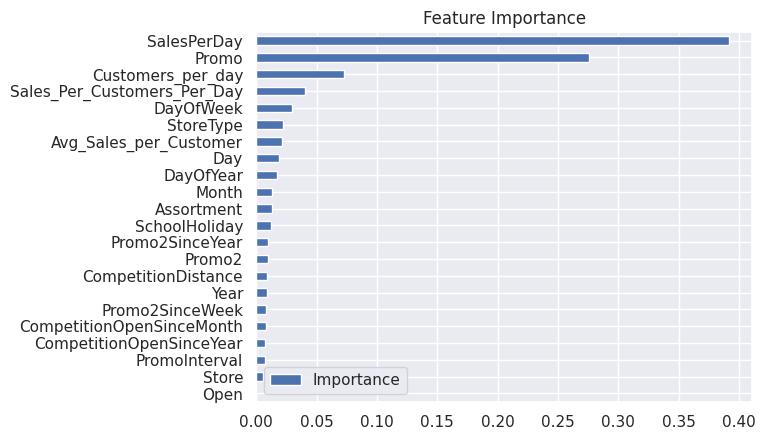

In [35]:
f1.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [36]:
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:57:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation RMSE: 606.98


In [37]:
m = train['Sales'].mean()

### Error Percentage

In [38]:
error = (rmse/m)*100
error

8.749941327738629

### Randomized Search

In [39]:
'''from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [1000, 1500,2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator= model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_) '''

'from sklearn.model_selection import RandomizedSearchCV\n\nparam_grid = {\n    \'n_estimators\': [1000, 1500,2000],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'max_depth\': [4, 6, 8],\n    \'subsample\': [0.7, 0.8, 1.0],\n    \'colsample_bytree\': [0.7, 0.8, 1.0]\n}\n\nrandom_search = RandomizedSearchCV(\n    estimator= model,\n    param_distributions=param_grid,\n    n_iter=20,\n    scoring=\'neg_root_mean_squared_error\',\n    cv=3,\n    verbose=1,\n    random_state=42\n)\n\nrandom_search.fit(X_train, y_train)\nprint("Best Params:", random_search.best_params_) '

#### Output of Randomized search was - Best Params: {'subsample': 1.0, 'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

#### I have used this parameter in my model